# Customer Lifetime Value

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib
from pandas.core.resample import TimeGrouper



random_state = 2026

In [202]:
df = pd.read_csv('online_retail_II.csv')

# Data Cleaning

In [203]:
df = df[~df['Invoice'].str.startswith('C')]
df = df.dropna(subset=['Customer ID'])
df = df[df['Price'] >= 0]
df = df[df['Quantity'] >= 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])



In [204]:
df.isna().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


# Exploratory Data Analysis

In [205]:
df.shape


(805620, 8)

In [206]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


In [208]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Univariate EDA

In [209]:
def plot_bar_with_labels(series, title="", xlabel="", ylabel=""):
    """
    Plots a bar chart from a pandas Series and adds value labels on top of each bar.

    Parameters:
        series (pd.Series): The data to plot (e.g., value_counts()).
        title (str): Title of the chart.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
    """
    ax = series.plot(kind='bar', title=title, xlabel=xlabel, ylabel=ylabel, rot=0)

    # Add labels on top of each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')  # center align horizontally, place above the bar

    plt.show()

In [210]:
df['Country'].nunique()

41

In [211]:
df['Country'].value_counts()

,count
Country,
United Kingdom,725296
Germany,16703
EIRE,15745
France,13813
Netherlands,5093
Spain,3720
Belgium,3069
Switzerland,3012
Portugal,2446


In [212]:
date_series = pd.to_datetime(df['InvoiceDate'])
date_series = pd.Series(date_series)

print("Median:", date_series.median())
print("Mean:", date_series.mean())
print("Max:", date_series.max())
print("Min:", date_series.min())

Median: 2010-12-03 15:10:00
Mean: 2011-01-02 10:26:35.704326144
Max: 2011-12-09 12:50:00
Min: 2009-12-01 07:45:00


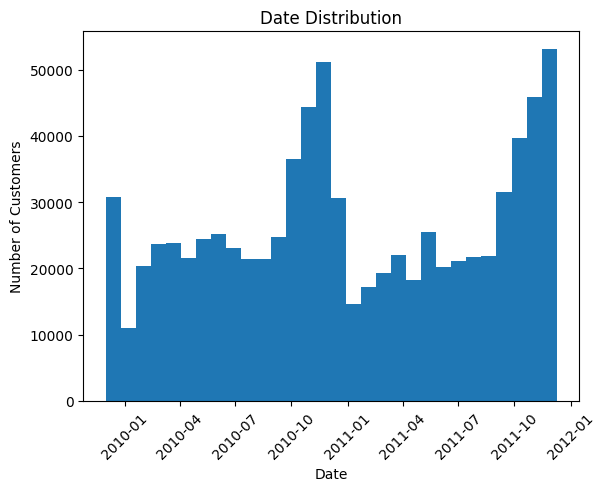

In [213]:
def plot_distribution(series, title="", xlabel=""):
    series_cleaned = series.dropna()
    plt.hist(series_cleaned, bins=30)
    plt.xticks(rotation=45)
    plt.title(f"{title} Distribution")
    plt.xlabel(xlabel)
    plt.ylabel("Number of Customers")
    plt.show()


dates = date_series.dt.date
plot_distribution(dates, "Date", "Date")

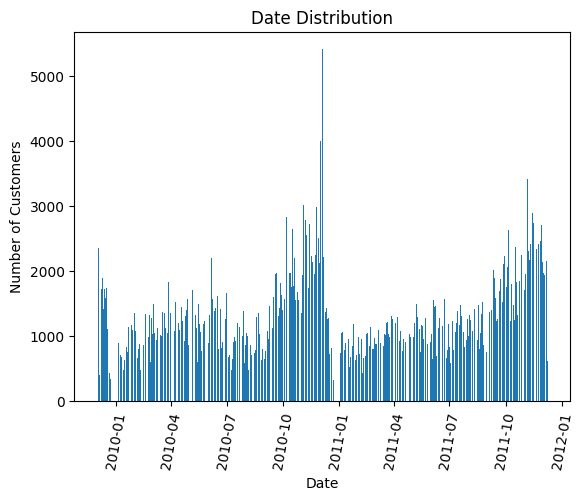

In [214]:
date_counts = date_series.dt.date.value_counts().sort_index()

plt.bar(date_counts.index, date_counts.values)
plt.xticks(rotation=80)
plt.title("Date Distribution")
plt.xlabel("Date")
plt.ylabel("Number of Customers")
plt.show()


In [215]:
df["InvoiceDate"].value_counts()

,count
InvoiceDate,
2011-11-14 15:27:00,542
2011-11-28 15:54:00,533
2011-12-05 17:17:00,529
2011-11-23 13:39:00,443
2011-10-31 14:09:00,435
...,...
2011-07-22 14:39:00,1
2009-12-01 13:48:00,1
2010-11-09 12:47:00,1


In [216]:
df['Customer ID'].value_counts()

,count
Customer ID,
17841.0,12890
14911.0,11247
12748.0,7230
14606.0,6566
14096.0,5111
...,...
14095.0,1
15657.0,1
14103.0,1


<Axes: title={'center': 'Active Customers Over Time'}, xlabel='month'>

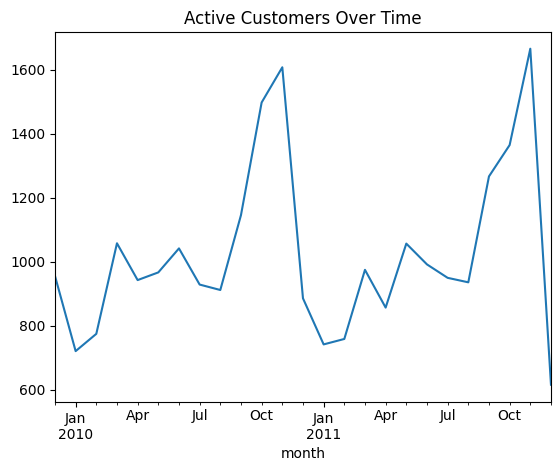

In [217]:
df["month"] = df["InvoiceDate"].dt.to_period("M")

df.groupby("month")["Customer ID"].nunique().plot(
    title="Active Customers Over Time"
)


# Creating a new database

In [218]:
# Finding the best cutoff
cutoffs = ["2010-01-01","2010-02-01","2010-03-01",
           "2010-04-01", "2010-05-01","2010-06-01",
           "2010-07-01", "2010-08-01", "2010-09-01",
           "2010-10-01", "2010-11-01", "2010-12-01",
           "2011-01-01", "2011-02-01", "2011-03-01",
           "2011-04-01", "2011-05-01", "2011-06-01",
           "2011-07-01", "2011-08-01", "2011-09-01",
           "2011-10-01", "2011-11-01", "2011-12-01"]

max_overlap = 0
best_cutoff = None

for c in cutoffs:
    c = pd.to_datetime(c)
    past = df[df["InvoiceDate"] < c]
    future = df[df["InvoiceDate"] >= c]

    overlap = (
        set(past["Customer ID"]) &
        set(future["Customer ID"])
    )
    if len(overlap) > max_overlap:
        max_overlap = len(overlap)
        best_cutoff = c
    print(c, len(overlap))
print(f"The Cut off with the most overlap: {best_cutoff}: {max_overlap}")

2010-01-01 00:00:00 866
2010-02-01 00:00:00 1192
2010-03-01 00:00:00 1493
2010-04-01 00:00:00 1831
2010-05-01 00:00:00 2033
2010-06-01 00:00:00 2196
2010-07-01 00:00:00 2359
2010-08-01 00:00:00 2450
2010-09-01 00:00:00 2507
2010-10-01 00:00:00 2606
2010-11-01 00:00:00 2713
2010-12-01 00:00:00 2726
2011-01-01 00:00:00 2683
2011-02-01 00:00:00 2659
2011-03-01 00:00:00 2675
2011-04-01 00:00:00 2687
2011-05-01 00:00:00 2656
2011-06-01 00:00:00 2602
2011-07-01 00:00:00 2529
2011-08-01 00:00:00 2453
2011-09-01 00:00:00 2344
2011-10-01 00:00:00 2120
2011-11-01 00:00:00 1689
2011-12-01 00:00:00 587
The Cut off with the most overlap: 2010-12-01 00:00:00: 2726


In [219]:
# January 1, 2011; the shape before and after have a similar pattern
cutoff = "2010-11-01"


# Convert cutoff string to a datetime object for proper comparison
cutoff_dt = pd.to_datetime(cutoff)


past_data = df[df["InvoiceDate"] < cutoff_dt].copy()
future_data = df[df["InvoiceDate"] >= cutoff_dt].copy()

# Calculate TotalPrice for future_data for the 'labels' before grouping
future_data['TotalPrice'] = future_data['Quantity'] * future_data['Price']
past_data['TotalPrice'] = past_data['Quantity'] * past_data['Price']

# Creating Features
features = past_data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (cutoff_dt - x.max()).days, # Recency
    "Invoice": "nunique", # Finds the Total number of requests
    "TotalPrice": "sum" # Price * Quantity sum
})

last_90_start = cutoff_dt - pd.DateOffset(days=90)
past_90 = past_data[past_data["InvoiceDate"] >= last_90_start]
spend_last_90 = (past_90.groupby('Customer ID')['TotalPrice'].sum().rename('spend_last_90_days'))

# Spend trend (last 90 - prev 90)
prev_90_start = cutoff_dt - pd.DateOffset(days=180)
prev_90_end = cutoff_dt - pd.DateOffset(days=90)

prev_90 = past_data[(past_data["InvoiceDate"] >= prev_90_start) & (past_data["InvoiceDate"] < prev_90_end) ]
spend_prev_90 = (prev_90.groupby("Customer ID")['TotalPrice'].sum().rename('spend_prev_90_days'))
spend_trend = (spend_last_90.subtract(spend_prev_90, fill_value=0).rename("SpendTrend"))

features = (features.join(spend_last_90).join(spend_trend).fillna(0))

# Rename the columns of the features DataFrame
features.rename(columns={'InvoiceDate' : 'Recency', 'Invoice' : 'Frequency', "TotalPrice" : "Monetary"}, inplace=True)

# Corrected: Use rename() for renaming columns
future_data.rename(columns={"TotalPrice": "FutureSpend"}, inplace=True)
labels = future_data.groupby("Customer ID")['FutureSpend'].sum()


model_df = features.merge(labels, on='Customer ID', how='left')
# Customers that didn't spend later on will be filled with 0
model_df['FutureSpend'] = model_df['FutureSpend'].fillna(0)

model_df['AverageOrderValue'] = model_df['Monetary'] / model_df['Frequency']


model_df.head()


,Recency,Frequency,Monetary,spend_last_90_days,SpendTrend,FutureSpend,AverageOrderValue
Customer ID,,,,,,,
12346.0,125,11,372.86,0.00,-142.31,77183.60,33.896364
12347.0,0,1,611.53,611.53,611.53,5021.79,611.530000
12348.0,34,1,222.16,222.16,222.16,1797.24,222.160000
12349.0,3,3,2671.14,1402.62,1202.62,1757.55,890.380000
12353.0,4,1,317.76,317.76,317.76,89.00,317.760000


## Explanation of Features
*   Recency: Number of days since last purchase
*   Frequency: How often the customer made a purchase
*   Monetary: Total spending customer made
*   spend_last_90_days: Total spending customer made within last 90 days
*   Spend Trend: Spending within last 90 days -  Spending within the 90 days previous to that.
*   Average Order Value: Monetary / Frequency
## Explanation of label
*   FutureSpend: Total spending made past cutoff


## Data Analysis of new dataframe

In [220]:
model_df.isna().sum()

,0
Recency,0
Frequency,0
Monetary,0
spend_last_90_days,0
SpendTrend,0
FutureSpend,0
AverageOrderValue,0


In [221]:
model_df[model_df['FutureSpend'] == 0].count()

,0
Recency,1230
Frequency,1230
Monetary,1230
spend_last_90_days,1230
SpendTrend,1230
FutureSpend,1230
AverageOrderValue,1230


In [222]:
model_df.shape

(3943, 7)

In [223]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3943 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             3943 non-null   int64  
 1   Frequency           3943 non-null   int64  
 2   Monetary            3943 non-null   float64
 3   spend_last_90_days  3943 non-null   float64
 4   SpendTrend          3943 non-null   float64
 5   FutureSpend         3943 non-null   float64
 6   AverageOrderValue   3943 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 246.4 KB


In [224]:
model_df.describe()

,Recency,Frequency,Monetary,spend_last_90_days,SpendTrend,FutureSpend,AverageOrderValue
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,89.047426,4.020289,1863.502215,612.584953,141.763782,2091.456763,381.150640
std,90.726008,7.169160,8091.895641,2484.336045,1691.266878,10125.806070,510.698016
min,0.000000,1.000000,0.000000,0.000000,-51237.230000,0.000000,0.000000
25%,18.000000,1.000000,293.590000,0.000000,-136.140000,0.000000,179.078125
50%,48.000000,2.000000,641.650000,222.660000,0.000000,459.400000,292.671429
75%,145.000000,4.000000,1577.860000,589.945000,327.190000,1634.365000,425.285000
max,334.000000,169.000000,299237.230000,82298.350000,50393.460000,313400.360000,11880.840000


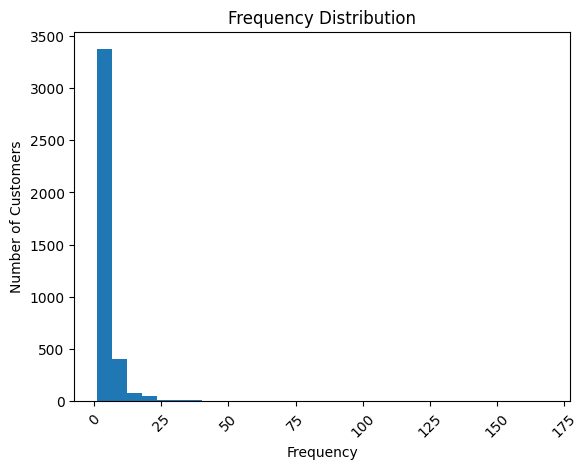

In [225]:
plot_distribution(model_df['Frequency'], "Frequency", "Frequency")

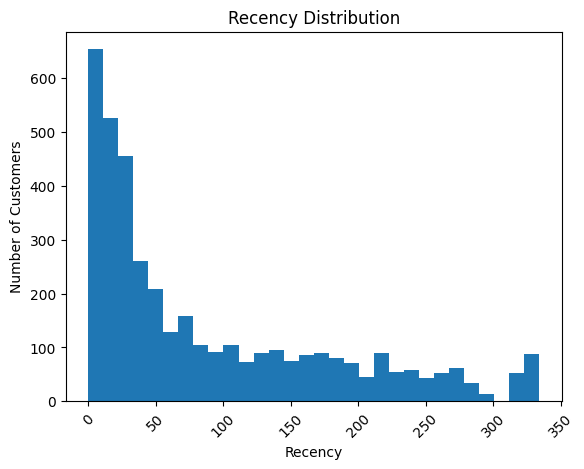

In [226]:
plot_distribution(model_df['Recency'], "Recency", "Recency")

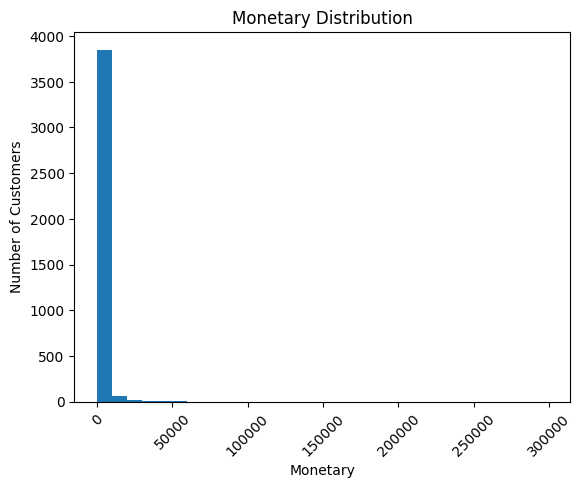

In [227]:
plot_distribution(model_df['Monetary'], "Monetary", "Monetary")

In [228]:
model_df['Monetary'].describe()

,Monetary
count,3943.000000
mean,1863.502215
std,8091.895641
min,0.000000
25%,293.590000
50%,641.650000
75%,1577.860000
max,299237.230000


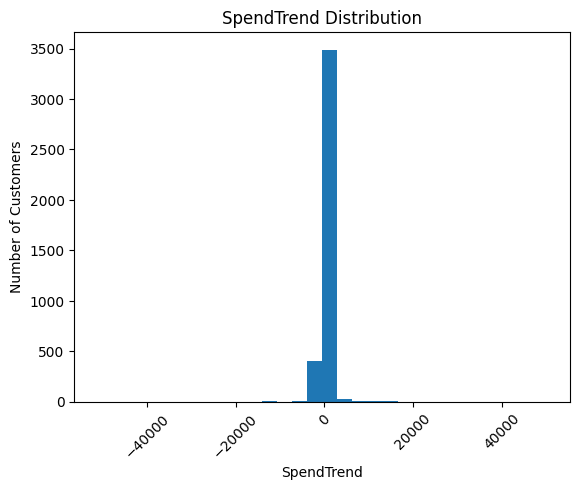

In [229]:
plot_distribution(model_df['SpendTrend'], "SpendTrend", "SpendTrend")

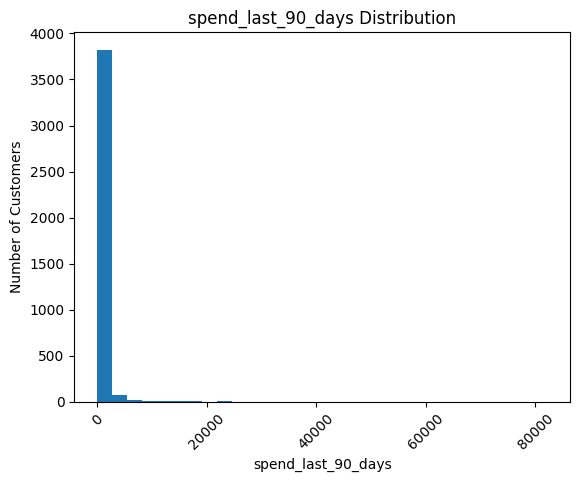

In [230]:
plot_distribution(model_df['spend_last_90_days'], "spend_last_90_days", "spend_last_90_days")

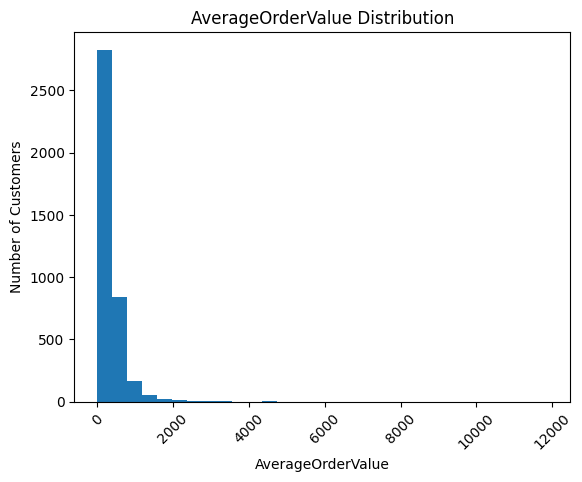

In [231]:
plot_distribution(model_df['AverageOrderValue'], "AverageOrderValue", "AverageOrderValue")

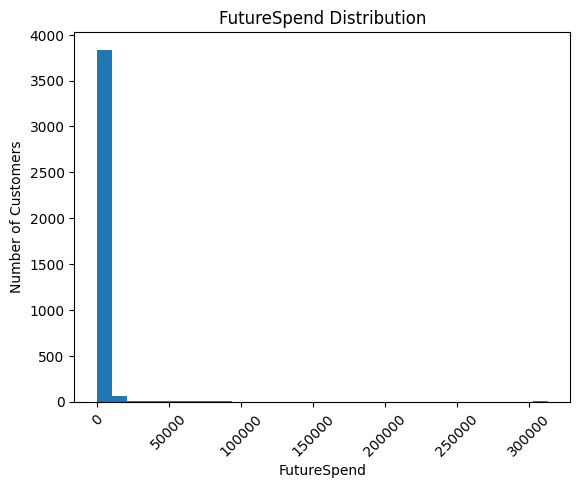

In [232]:
plot_distribution(model_df['FutureSpend'], "FutureSpend", "FutureSpend")

In [233]:
# If the cutoff date results in zero being the higher result, than we'll move the bins upwards
low_split = model_df['FutureSpend'].quantile(0.25)
if low_split == 0:
  print("The Bins have been moved upwards")
  no_spend = model_df[model_df['FutureSpend'] > 0]['FutureSpend']
  high_split = no_spend.quantile(0.75)
  low_split = no_spend.quantile(0.25)
else:
  high_split = model_df['FutureSpend'].quantile(0.75)
print(f"Low Split: {low_split} and High Split: {high_split}")

The Bins have been moved upwards
Low Split: 415.7 and High Split: 2504.13


In [234]:
# Creating new labels
bins = [1, low_split, high_split, model_df['FutureSpend'].max()]
labels = ["Low", "Medium", "High"]

def categorize_future_spend(value):
    if value == 0:
      return "Zero"

    else:
      cut_series = pd.cut(pd.Series(value), bins=bins, labels=labels)
      return cut_series.iloc[0]
# Multi-Class
model_df['FutureSpendCategory'] = model_df['FutureSpend'].apply(categorize_future_spend)

# Binary
model_df["HighValue"] = model_df["FutureSpendCategory"] == "High"
labels.insert(0, "Zero")
model_df.head()



,Recency,Frequency,Monetary,spend_last_90_days,SpendTrend,FutureSpend,AverageOrderValue,FutureSpendCategory,HighValue
Customer ID,,,,,,,,,
12346.0,125,11,372.86,0.00,-142.31,77183.60,33.896364,High,True
12347.0,0,1,611.53,611.53,611.53,5021.79,611.530000,High,True
12348.0,34,1,222.16,222.16,222.16,1797.24,222.160000,Medium,False
12349.0,3,3,2671.14,1402.62,1202.62,1757.55,890.380000,Medium,False
12353.0,4,1,317.76,317.76,317.76,89.00,317.760000,Low,False


In [235]:
model_df['FutureSpendCategory'].value_counts()

,count
FutureSpendCategory,
Medium,1356
Zero,1230
Low,679
High,678


## The New Labels


*   FutureSpendCategory: splits customer's future spending into high, medium, low, and zero spending
*   HighValue: Whether the customer is a high spender in the future



# Exploratory Data Analysis of New Dataset

In [236]:
def plot_bar_with_labels(series, title="", xlabel="", ylabel=""):
    """
    Plots a bar chart from a pandas Series (single or MultiIndex) and adds value labels.

    Parameters:
        series (pd.Series): Data to plot, can be value_counts() or groupby().value_counts()
        title (str): Chart title
        xlabel (str): Label for x-axis
        ylabel (str): Label for y-axis
    """

    ax = series.plot(kind='bar', title=title, rot=45)
    # Format x-axis labels for MultiIndex
    if isinstance(series.index, pd.MultiIndex):
        ax.set_xticklabels([' & '.join(map(str, idx)) for idx in series.index])

    # Add labels on top of each bar
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()


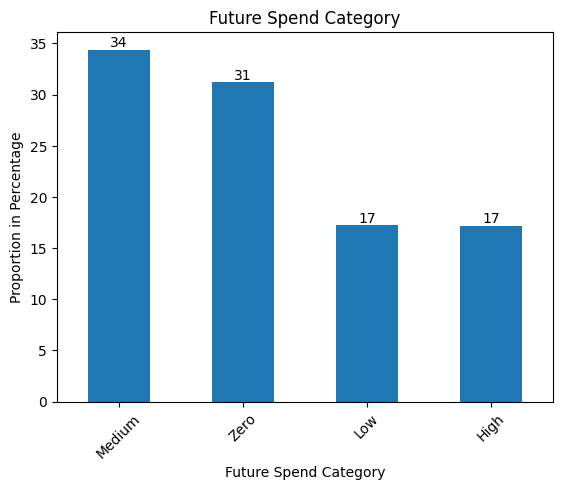

In [237]:
plot_bar_with_labels(model_df['FutureSpendCategory'].value_counts(normalize=True) * 100, "Future Spend Category", "Future Spend Category", "Proportion in Percentage")

Model Pipeline Preparation

In [238]:
# We're going to ignore futurespend
ordinal_features = 'FutureSpendCategory'
numerical_features = ['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'SpendTrend', 'spend_last_90_days']


numerical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features)
    ])

In [239]:
print(labels)
print(numerical_features)

['Zero', 'Low', 'Medium', 'High']
['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'SpendTrend', 'spend_last_90_days']


# Final Model Selection

In [240]:
# Models chosen: RandomForrest, Gradient Boost Machines (XGBoost), Logistic Regression, KNN, SVM, Naive Bayes

models = {
    "Random Forest" : RandomForestClassifier(class_weight='balanced', random_state=random_state),
    "XGBoost" : XGBClassifier(random_state=random_state),
    "Logistic Regression" : LogisticRegression(class_weight='balanced', random_state=random_state),
    "KNN" : KNeighborsClassifier(),
    "SVM" : SVC(class_weight='balanced',random_state=random_state, probability=True),
    "Naive Bayes" : GaussianNB()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

x = model_df.drop(columns = ['FutureSpend','FutureSpendCategory', 'HighValue'], axis=1)
y_multi = model_df['FutureSpendCategory'].map({"Zero" : 0, "Low" : 1, "Medium" : 2, "High" : 3})
y_binary = model_df['HighValue'].map({False : 0, True : 1})


x_train_multi, x_test_multi, y_train_multi, y_test_multi = train_test_split(x, y_multi, test_size=0.2, random_state=random_state)
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(x, y_binary, test_size=0.2, random_state=random_state)

def evaluate_model(x_test, y_test, cv):
  for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    scores = cross_val_score(pipe, x_test, y_test, cv=cv, scoring='roc_auc_ovr_weighted')
    print(f"{name}'s Mean Cross Validation Score: {scores.mean()}")
print("Multi-Classification")
evaluate_model(x_test_multi, y_test_multi, cv)
print("\nBinary Classification")
evaluate_model(x_test_binary, y_test_binary, cv)

Multi-Classification
Random Forest's Mean Cross Validation Score: 0.7099673973353774
XGBoost's Mean Cross Validation Score: 0.6991045355074468
Logistic Regression's Mean Cross Validation Score: 0.7476701332690386
KNN's Mean Cross Validation Score: 0.6926173909330281
SVM's Mean Cross Validation Score: 0.7571354783881985
Naive Bayes's Mean Cross Validation Score: 0.7336169095899653

Binary Classification
Random Forest's Mean Cross Validation Score: 0.8691847935044106
XGBoost's Mean Cross Validation Score: 0.8493141873830528
Logistic Regression's Mean Cross Validation Score: 0.8860239574979951
KNN's Mean Cross Validation Score: 0.834371240978348
SVM's Mean Cross Validation Score: 0.8824403568564554
Naive Bayes's Mean Cross Validation Score: 0.8724797848168938


SVM is best for Multi-Classification. Logistic Regression is best for binary classification

# Final Metrics

Best SVM model

In [241]:
best_model_multi = SVC(kernel = 'rbf', gamma=0.1, class_weight='balanced', probability=True, random_state=random_state)
pipe_multi = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", best_model_multi)])
pipe_multi.fit(x_train_multi, y_train_multi)
y_pred = pipe_multi.predict(x_test_multi)
y_prob = pipe_multi.predict_proba(x_test_multi)

print(classification_report(y_test_multi, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test_multi, y_prob, multi_class='ovr', average='weighted')}")


              precision    recall  f1-score   support

           0       0.53      0.54      0.54       226
           1       0.30      0.43      0.35       134
           2       0.57      0.39      0.47       284
           3       0.62      0.72      0.67       145

    accuracy                           0.50       789
   macro avg       0.51      0.52      0.51       789
weighted avg       0.52      0.50      0.50       789

ROC AUC Score: 0.7625490371334974


Best Logistic Regression Model

In [242]:
best_model_binary = LogisticRegression(max_iter=100, penalty='l1', solver='liblinear', class_weight='balanced', random_state=random_state)
pipe_binary = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", best_model_binary)])
pipe_binary.fit(x_train_binary, y_train_binary)
y_pred = pipe_binary.predict(x_test_binary)
y_prob = pipe_binary.predict_proba(x_test_binary)
print(classification_report(y_test_binary, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test_binary, y_prob[:, 1])}")



              precision    recall  f1-score   support

           0       0.94      0.86      0.90       644
           1       0.56      0.77      0.65       145

    accuracy                           0.85       789
   macro avg       0.75      0.81      0.77       789
weighted avg       0.87      0.85      0.85       789

ROC AUC Score: 0.8827479117584065


Finding Best Threshold

In [243]:
probs = pipe_binary.predict_proba(x_test_binary)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_binary, probs)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)

best_threshold = round(thresholds[best_idx], 1)
print("Best threshold:", best_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])
print("F1:", f1[best_idx])


Best threshold: 0.6
Precision: 0.6666666666666666
Recall: 0.6620689655172414
F1: 0.6643598565917554


In [244]:
y_pred_binary = (probs >= best_threshold).astype(int)
print(classification_report(y_test_binary, y_pred_binary))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92       644
           1       0.64      0.68      0.66       145

    accuracy                           0.87       789
   macro avg       0.78      0.80      0.79       789
weighted avg       0.87      0.87      0.87       789



# Feature Importance / Interpretation

In [245]:
def get_feature_importance(pipe):
  coef = pipe.named_steps['classifier'].coef_[0]
  feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
  importance = pd.Series(coef, index=feature_names)


  bottom = importance.sort_values(ascending=False).head(10)
  pd.concat([bottom]).plot(kind='barh', figsize=(8, 6))
  plt.title('Top Factors Influencing Future Spending')
  plt.show()


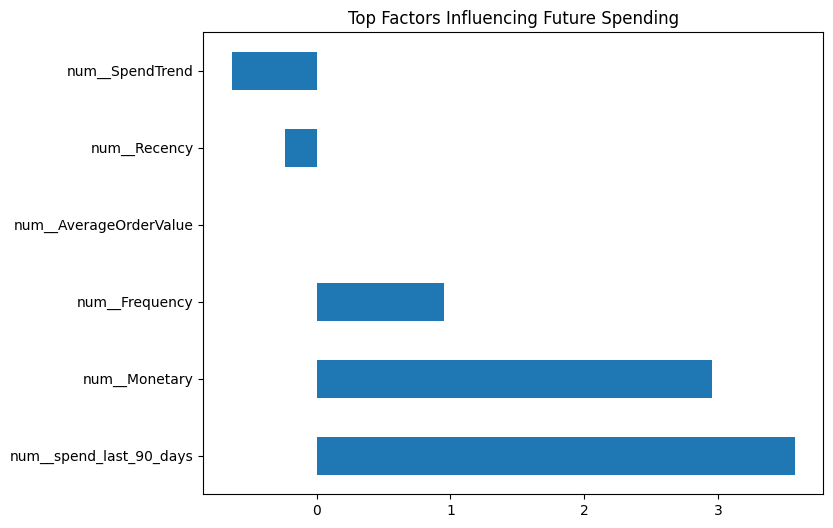

,0
num__spend_last_90_days,3.575558
num__Monetary,2.955502
num__Frequency,0.954628
num__AverageOrderValue,0.000000
num__Recency,-0.236032
num__SpendTrend,-0.634184


In [246]:
get_feature_importance(pipe_binary)
coef = pipe_binary.named_steps['classifier'].coef_[0]
feature_names = pipe_binary.named_steps['preprocessor'].get_feature_names_out()

importance = pd.Series(coef, index=feature_names)
importance.sort_values(ascending=False)

# Business Insights

High Value Spenders will be the top 25% of customers in futurespend.

Zero-spenders will be excluded from percentile calculation to prevent a skewing of results towards zero.


### What does the model learn?
Based on the feature importance, it learns...
*   Customers who spend a lot within the last 90 days are more likely to be high value customers
*   Customers who spend a lot in general are more likely to be high value customers
*   Customers who purchase more frequently are more likely to be high value customers
*   Customers with a negative spending trend are less likely to be high value customers

### What does negative spend trend mean?
Customers whose spending is declining will have a negative spend trend. Therefore, they're at risk of becoming low-value or inactive
### Why does this matter?
Retention tends to be cheaper than acquiring new customers through marketing. Therefore, keeping high-value customers who spend a high amount should be a priority



# Business Action Enabled by Model


1.   High Value -> Loyalty Rewards, early product access
2.   Medium Value -> Upsell / bundle offers
3. Low Value -> Reactivation campaigns
4. Zero Spending -> Churn Prevention


# Model Limitations


*   Database is from only 1 UK-based online-only retail company
*   No marketing exposure data
*   Assumes behavior stability
*   Currency is not normalized for inflation
*   Dated pre-pandemic in 2009-2011


# Conclusion
This project demonstrated an end-to-end approach to Customer Lifetime Value (CLV) prediction, combining transactional data engineering, robust feature construction, and supervised machine learning to identify high-value customers before their future purchasing behavior is observed.

Using historical transaction data, customer-level features were engineered to capture recency, frequency, and monetary behavior, along with short- and medium-term spending dynamics. A time-based train–test split with a clearly defined cutoff date ensured realistic evaluation and prevented data leakage, closely mirroring real-world deployment scenarios.

For modeling, both binary and multi-class classification approaches were explored. Logistic Regression was selected as the primary model for binary high-value prediction due to its strong performance (ROC-AUC ≈ 0.88), stability under cross-validation, and interpretability. While more complex models such as SVMs were evaluated, the simpler linear model achieved comparable or superior performance, reinforcing the importance of aligning model complexity with business needs.

Class imbalance was considered explicitly, with ROC-AUC chosen as the primary evaluation metric due to its robustness. Precision and recall for the high-value customer class were also analyzed to ensure the model remained practically useful for targeted business actions such as retention campaigns and personalized marketing.

Key findings indicate that customer engagement patterns and recent spending behavior are strong predictors of future value. Customers with frequent purchases, higher recent spend, and sustained activity over time are significantly more likely to generate high future revenue, validating well-established customer lifecycle theories.

Overall, this project highlights how machine learning can be effectively applied to transactional data to support data-driven decision-making, enabling businesses to prioritize retention efforts, optimize marketing spend, and proactively identify customers with the highest long-term value.

# Saving of model
I'll use the binary model, because it has the higher ROC-AUC

In [247]:
joblib.dump(pipe_binary, 'mymodel.joblib')


['mymodel.joblib']